<a href="https://colab.research.google.com/github/anna-dang/dsc-phase-4-project/blob/main/project_4_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision: X-Ray Classification using Neural Networks

Objective: Build a model that can classify whether a given patient has pneumonia, given a chest x-ray image.

Sources: [original image source](http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5), [data download source](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)


### Import libraries

In [ ]:
!pip install lime

In [ ]:
!pip install visualkeras

In [ ]:
import os, random, cv2, visualkeras 

import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
from sklearn import metrics
from collections import defaultdict
from lime import lime_image
from skimage.segmentation import mark_boundaries

from tensorflow.keras import callbacks, models, layers, optimizers, regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

seed = 3
np.random.seed(seed)

### Define functions

In [ ]:
def get_num_images(file_path, form='total'):
    """ Follows a filepath for this dataset and counts the images per class of NORMAL or PNEUMONIA X-rays.
        Option to return the 'total' elements per folder or a 'tuple' of the count for each type,
        or the 'normed' count (percentage per class of total).

        Output format: (NORMAL, PNEUMONIA) """    

    # Calculate quantities
    normal = len(os.listdir(file_path + '/NORMAL'))
    pneum = len(os.listdir(file_path + '/PNEUMONIA'))
    tot = normal + pneum

    # Format return type
    if form == 'total':
        return tot
    if form == 'normed':
        return tuple(round(i, 3) for i in ((normal/tot), (pneum/tot)))
    if form == 'tuple':
        return (normal, pneum) 



def plot_raw_images(norm_imgs, pneu_imgs, samples):
    """ Displays selected number of raw images direct from training file for each class."""

    # Randomly select images from both classes to inspect
    pneu_imgs = np.random.choice(os.listdir(train_path + '/PNEUMONIA/'), samples, replace = False)
    norm_imgs = np.random.choice(os.listdir(train_path + '/NORMAL/'), samples, replace = False)
  
    # Plot images
    fig, axes = plt.subplots(nrows=2, ncols=samples, figsize=(25, 25))
    for i, img in enumerate(norm_imgs):
        axes[0, i].imshow(cv2.imread(train_path + '/NORMAL/' + img))
        axes[0, i].set_title(f"Normal Lungs, {i + 1}")
    for i, img in enumerate(pneu_imgs):   
        axes[1, i].imshow(cv2.imread(train_path + '/PNEUMONIA/' + img))
        axes[1, i].set_title(f"Pnuemonia Lungs, {i + 1}")
    plt.subplots_adjust(bottom=0.3, top=0.6, hspace=0)
    plt.show()



def plot_metrics(history, df=False):
    """ Input model history (from 'model.fit'), 
        Return visualizations for pre-defined metrics.
        Option to return training history DataFrame."""

    metrics = ['loss', 'accuracy', 'precision', 'recall']
    plt.figure(figsize=(12,8))
    # plot train vs test for each metric
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='indigo', 
                 label='Train', zorder=3);
        plt.plot(history.epoch, history.history['val_'+metric], color='steelblue', 
                 label='Validate', linestyle="--", zorder=5);
        plt.grid(color='whitesmoke', zorder=0)
        plt.xlabel('Epoch')
        plt.ylabel(name, size=12)
        plt.legend()
        plt.suptitle("Model Training Performance")
    if df == True:
        pd.DataFrame(history.history)
    


def evaluate_model(model, images, labels, return_preds=False, norm_type='true'):
    """ Given model and predictors/labels, returns model performance evaluation
        as Classification Report Table and two confusion matrices (one with 
        prediction class distribution and one normalized (default: 'true').

        Optional: return predicted labels."""

    # Get binary predictions by round predicted probabilities
    y_hat= model.predict(images).round()
    
    # Print classification report
    print("---"*20)
    print("Classification Report for Test Data: \n")
    print(metrics.classification_report(labels, y_hat))
    print("---"*20)
    
    # Build confusion matrix
    print("Model Predictions Results for Test Data:")
    cm = metrics.confusion_matrix(labels, y_hat, normalize='all')
    cm_true = metrics.confusion_matrix(labels, y_hat, normalize='true')

    # Set figure
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(16,4) )

    # Plot quantity distribution confusion matrix
    sns.heatmap(cm, annot=True, fmt='.0%', cmap="BuPu", square=True, ax=ax1);
    ax1.set(title='Distribution of Predictions',ylabel='True Class', xlabel='Predicted Class')

    # Plot normalized matrix (to ROWS, true values)
    sns.heatmap(cm_true, annot=True, fmt='.0%', cmap="BuPu", square=True, ax=ax2);
    ax2.set(title='Normalized to True Class',ylabel='True Class', xlabel='Predicted Class')

    # Calculate 'false-positive rate', 'true-positive rate' and 'area under curve' (AUC)
    fpr , tpr , thresholds = metrics.roc_curve(labels, y_hat)
    auc_score = metrics.roc_auc_score(labels, y_hat)

    ax3.plot(fpr,tpr, color='indigo'); 
    ax3.axis([0,1,0,1]) 
    ax3.set(xlabel ='False Positive Rate', ylabel ='True Positive Rate', 
            title = f"ROC Curve, AUC = {auc_score:.2f}")
    #ax3.title(f"ROC Curve, AUC: {round(auc_score), 3}", size=15)
    ax3.grid(color='whitesmoke', zorder=0)
    plt.show()

    # If selected, return predicted labels
    if return_preds == True:
        return y_hat

        

In [ ]:
# Set custom color map for 'visualkeras'
color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'aliceblue'
color_map[MaxPooling2D]['fill'] = 'thistle'
color_map[Flatten]['fill'] = 'slateblue'
color_map[Dense]['fill'] = 'indigo'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Download data

In [ ]:
# Mount the connection to Google Drive
drive.mount('/gdrive',force_remount=True)

Mounted at /gdrive


In [ ]:
# Check current directory (the 'local' directory where Colab operates)
os.getcwd()

'/content'

In [ ]:
# Define 'local' path as the directory of the virtual machine (where Colab runs)
local_path = '/content'

# Path to this project fold gdrive to save any models/variables
project_path = '/gdrive/MyDrive/mod04/'

# Path where data .zip file is stored on Google Drive
zip_path = '/gdrive/MyDrive/kaggle/chest-xray-pneumonia.zip'

# Copy .zip file into virtual machine
!cp '{zip_path}' .

In [ ]:
# Unzip in virtual machine/pwd
!unzip -q 'chest-xray-pneumonia.zip'

  error:  invalid compressed data to inflate chest_xray/chest_xray/train/NORMAL/IM-0684-0001.jpeg


In [ ]:
# Establish file paths for each of the unzipped data folders on the virtual machine
train_path = '/content/chest_xray/train'
test_path = '/content/chest_xray/test'
val_path = '/content/chest_xray/val'

# Count images per path
[get_num_images(path, form='total') for path in [train_path, test_path, val_path]]

[5216, 624, 16]

In [125]:
# Quick examine of the class distribution for each set as items and then percentage split
# Tuple presented as (Normal, Pneumonia)
display([x.split('/')[-1] for x in [train_path, test_path, val_path]])
display([get_num_images(path, form='tuple') for path in [train_path, test_path, val_path]])
[get_num_images(path, form='normed') for path in [train_path, test_path, val_path]]

['train', 'test', 'val']

[(1341, 3875), (234, 390), (8, 8)]

[(0.257, 0.743), (0.375, 0.625), (0.5, 0.5)]

### Preview data

There are two main class types: 'Normal' (class 0) and 'Pneumonia' (class 1). 

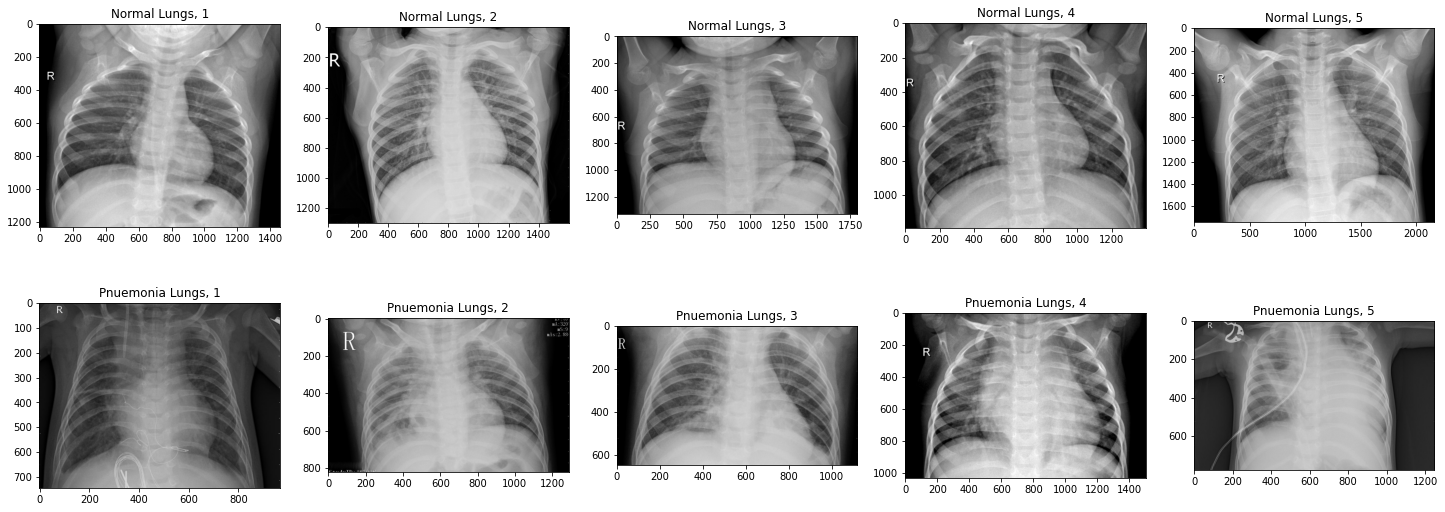

In [ ]:
# Randomly select images from both classes to inspect
pneu_imgs = np.random.choice(os.listdir(train_path + '/PNEUMONIA/'), samples, replace = False)
norm_imgs = np.random.choice(os.listdir(train_path + '/NORMAL/'), samples, replace = False)

# Select number of images
samples = 5

# Preview unprocessed images sized to fit in single row (keep original aspect ratio)
plot_raw_images(norm_imgs, pneu_imgs, samples)

Without medical traing and just a visual inspection - we see somewhat more opacity in the pneumonia lungs. This could be part of the pattern the model will recognize.


In [ ]:
# Check original image pixel dimensions
# Check number of pixel channels (the third dimension) to determine if RGB or grayscale

print([cv2.imread(train_path + '/NORMAL/' + img).shape for img in norm_imgs])
print([cv2.imread(train_path + '/PNEUMONIA/' + img).shape for img in pneu_imgs])

[(1723, 1800, 3), (1296, 1738, 3), (1121, 1646, 3), (1013, 1284, 3), (1259, 1654, 3)]
[(608, 992, 3), (688, 1032, 3), (656, 928, 3), (544, 976, 3), (1384, 1592, 3)]


Note there is a variety in image dimensions (image size is not standardized) and there are 3 color channels. Indicating that while these X-rays appear gray, they should be treated as full RGB for the model. The resolution is too large for training resources so the images will be resized to the smallest size without sacrificing model performance.

# Modeling


### Class Imbalance




On first inspection the training data is heavily unbalanced, favoring pnuemonia images. This could skew the training of the model as it will not be sufficiently trained on what 'normal' lungs look like compared to the pneumonia lungs. Data-oversampling and class weighting are equivalent. Copying the samples of a class 3X is equivalent to assigning a 3X weight to the class. However, the weighting is better from storage and computational point of view since it avoids working with a larger data-set. I will correct this balance by calculating class weights to train the model with.

,Quantity,Proportion
Normal,1341,0.257
Pneumonia,3875,0.743


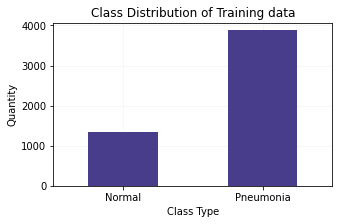



Pneumonia is represented 2.89 times as much by the data.


In [ ]:
# Display proportion by class for training set
normed = get_num_images(train_path, form='normed')
total = get_num_images(train_path, form='tuple')
total_s = pd.Series(data={'Normal': total[0], 'Pneumonia': total[1]}, name= 'Quantity').to_frame()
norm_s = pd.Series(data={'Normal': normed[0], 'Pneumonia': normed[1]}, name= 'Proportion').to_frame()
class_frame = pd.concat([total_s, norm_s], axis=1)
display(class_frame)
print('\n')

# Plot the distribution as a bar graph
class_frame['Quantity'].plot.bar(figsize=(5,3), legend=False, rot=0, 
                                 color='darkslateblue', zorder=3)
plt.title('Class Distribution of Training data')
plt.xlabel("Class Type")
plt.ylabel("Quantity")
plt.grid(color="whitesmoke", zorder=0)
plt.show()

print("\n")
print(f"Pneumonia is represented {round(total[1]/total[0], 2)} times as much by the data.")

In [ ]:
# Set class weights according to Keras documentation
weight_for_0 = (1 / total[0])*(get_num_images(train_path, form='total'))/2.0 
weight_for_1 = (1 / total[1])*(get_num_images(train_path, form='total'))/2.0

class_weight = {0.0: weight_for_0, 1.0: weight_for_1}

print('Weight for class 0 (Normal): {:.2f}'.format(weight_for_0))
print('Weight for class 1 (Pnuemonia): {:.2f}'.format(weight_for_1))

Weight for class 0 (Normal): 1.94
Weight for class 1 (Pnuemonia): 0.67


### Metrics

Which type of wrong answers are most concerning:

- Accuracy is the percentage of examples correctly classified

- Precision is the percentage of predicted positives that were correctly classified

- Recall is the percentage of actual positives that were correctly classified. Model guessing all target class will get a 100% recall.

In disease screening of patients for follow-up examinations, we would probably want a recall near 1.0 — we want to find all patients who actually have the disease so treatment can beging. We can accept a low precision if the cost of the follow-up examination is not significant. However, in cases where we want to find an optimal blend of precision and recall we can combine the two metrics and check F1 score on the test set.

In [ ]:
mod_metrics = ['accuracy', 
               tf.keras.metrics.Precision(name='precision'), 
               tf.keras.metrics.Recall(name='recall')]       


### Callbacks


A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).

- Early Stopping: Stop training when a monitored metric has stopped improving.

- Save model weights at some frequency or "best performance".

-


```
# To save models
model_path_filename = project_path +'model.hd5'
model.save(model_path_filename)

# Load model
model_loaded = load_model(model_path_filename)

# Load weights (that are considered the best) into the model
model.load_weights(checkpoint_filepath)
```

In [ ]:
# Set baseline call backs
earlystop = callbacks.EarlyStopping(verbose=1, 
                                    monitor='val_accuracy', 
                                    min_delta=0.01, 
                                    patience=3)

checkpoint = callbacks.ModelCheckpoint(filepath=project_path+"weights.{epoch:02d}-{val_accuracy:.2f}.hdf5",
                                       save_weights_only=True, 
                                       monitor='val_accuracy',
                                       mode='max',
                                       save_best_only=True)

call_list = [earlystop, checkpoint]

## Modeling

Convolutional Neural Networks (CNN)


#### CNN Preprocessing

In [ ]:
# Set image size, validation split percentage
target_img_size = (128, 128)
val_split_size = 0.25

# Rescale images to reduce RBG values to between 0 and 1
# Instantiate training set image generator
train_datagen = ImageDataGenerator(rescale=(1./255))
                                   
# Data used to train model
print(" Train:")
train_generator = train_datagen.flow_from_directory(train_path, 
                                                    target_size=target_img_size,
                                                    batch_size=64, #get_num_images(train_path))  
                                                    class_mode='binary',
                                                    seed=seed) 

# Blind test data for model evaluation, no modifications (except rescale)
# Split into test/validation split, label the subsets
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=val_split_size)  

# Data for use as validation in modeling to score model performance
print("\n Validation:")
val_generator = test_datagen.flow_from_directory(test_path, 
                                                      target_size=target_img_size,
                                                      class_mode='binary',
                                                      batch_size=64, #get_num_images(test_path),
                                                      subset='validation', 
                                                      seed=seed) 

# Data for testing completed model
print("\n Test:")
test_generator = test_datagen.flow_from_directory(test_path, 
                                                      target_size=target_img_size,
                                                      class_mode='binary',
                                                      batch_size=64, #get_num_images(test_path),
                                                      subset='training',
                                                      seed=seed)  

# Check for class types
print("\n Class Types:", train_generator.class_indices )

 Train:
Found 5216 images belonging to 2 classes.

 Validation:
Found 155 images belonging to 2 classes.

 Test:
Found 469 images belonging to 2 classes.

 Class Types: {'NORMAL': 0, 'PNEUMONIA': 1}


In [ ]:
# Format test images for evaluation
test_images, test_labels = next(test_generator)

# Verify single image size output by the generator 
input_image_size = test_images[0].shape
input_image_size

(128, 128, 3)

#### Iteration 1 : Baseline CNN

I will begin with one convolution block of two convolution layers to check baseline metrics. Then I will grow the model until it is just over fit. Then I will tune/early stop to reduce validation loss. Hopefully bringing overall model perfomance to a balanced metric.

In [ ]:
# Instantiate model
cnn = Sequential()

# First Conv layer
cnn.add(Conv2D(128, (3, 3), input_shape = input_image_size, activation = 'relu'))
cnn.add(Conv2D(64, (3, 3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Flatten the Conv layers for input into dense layer
cnn.add(Flatten())

# A hidden dense layer followed by the final binary classifying neuron
cnn.add(Dense(units = 128, activation = 'relu'))
cnn.add(Dense(units = 1, activation = 'sigmoid'))

# Compile the model and check architecture
cnn.compile(optimizer = 'adam', 
                loss = 'binary_crossentropy',
                metrics = mod_metrics)

# Preview model arhitecture
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 126, 126, 128)     3584      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 124, 124, 64)      73792     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 246016)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               31490176  
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 31,567,681
Trainable params: 31,567,681
Non-trainable params: 0
__________________________________________

In [ ]:
# Train the model
history = cnn.fit(train_generator, 
                              #steps_per_epoch=100, 
                              epochs=15, 
                              validation_data=val_generator,
                              class_weight=class_weight,
                              callbacks=call_list)

Epoch 1/15
82/82 [==============================] - 54s 657ms/step - loss: 0.6983 - accuracy: 0.7891 - precision: 0.9285 - recall: 0.7469 - val_loss: 0.6310 - val_accuracy: 0.7226 - val_precision: 0.7077 - val_recall: 0.9485
Epoch 2/15
82/82 [==============================] - 53s 648ms/step - loss: 0.1279 - accuracy: 0.9544 - precision: 0.9840 - recall: 0.9541 - val_loss: 0.8251 - val_accuracy: 0.7419 - val_precision: 0.7080 - val_recall: 1.0000
Epoch 3/15
82/82 [==============================] - 53s 648ms/step - loss: 0.0856 - accuracy: 0.9688 - precision: 0.9897 - recall: 0.9680 - val_loss: 0.5857 - val_accuracy: 0.7742 - val_precision: 0.7500 - val_recall: 0.9588
Epoch 4/15
82/82 [==============================] - 52s 636ms/step - loss: 0.0528 - accuracy: 0.9793 - precision: 0.9942 - recall: 0.9778 - val_loss: 0.9805 - val_accuracy: 0.7484 - val_precision: 0.7132 - val_recall: 1.0000
Epoch 5/15
82/82 [==============================] - 52s 630ms/step - loss: 0.0314 - accuracy: 0.9883

------------------------------------------------------------
Classification Report for Test Data: 

              precision    recall  f1-score   support

         0.0       1.00      0.20      0.33        20
         1.0       0.73      1.00      0.85        44

    accuracy                           0.75        64
   macro avg       0.87      0.60      0.59        64
weighted avg       0.82      0.75      0.69        64

------------------------------------------------------------
Model Predictions Results for Test Data:


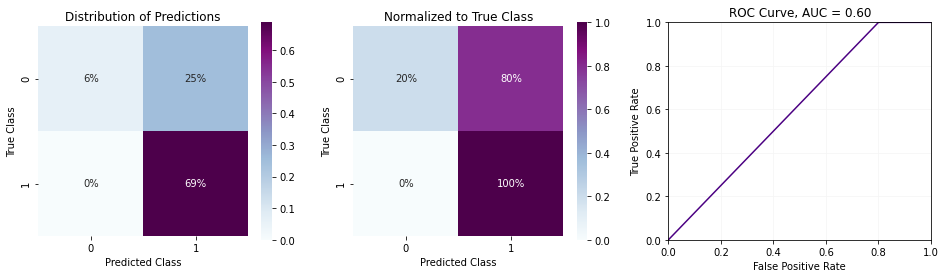

None

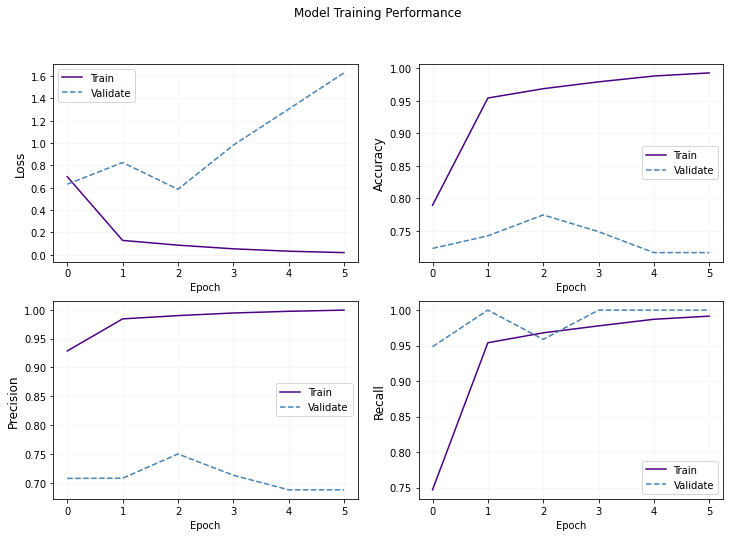

In [ ]:
# Evaluate model performance
display(evaluate_model(cnn, test_images, test_labels))
plot_metrics(history)

This shallow network is almost exclusively labeling pneumonia (94% of predictions). This gives a misleading 100% recall. I have used class weights to try and nudge it into learning normal lungs. Will attempt more tuning.

#### Iteration 2 :

In [126]:
cnn2 = Sequential([Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same',input_shape=input_image_size),
                  MaxPooling2D(pool_size=(2, 2), strides=2),
                  Conv2D(64, kernel_size=(5, 5), activation='relu'),
                  MaxPooling2D(pool_size=(2, 2), strides=2),
                  Flatten(),
                  Dense(120, activation='relu'),
                  Dense(84, activation='relu'),
                  Dense(1, activation = 'sigmoid')])

cnn2.compile(optimizer = 'adam', 
                loss = 'binary_crossentropy',
                metrics = mod_metrics)
cnn2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 128, 128, 128)     3584      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 60, 60, 64)        204864    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 120)               6912120   
_________________________________________________________________
dense_12 (Dense)             (None, 84)               

In [127]:
history2 = cnn2.fit(train_generator,
                              epochs = 10, 
                              validation_data = val_generator,
                              callbacks = call_list,
                              class_weight=class_weight)

Epoch 1/10
82/82 [==============================] - 54s 655ms/step - loss: 0.3462 - accuracy: 0.8411 - precision: 0.9303 - recall: 0.8474 - val_loss: 0.6212 - val_accuracy: 0.7677 - val_precision: 0.7293 - val_recall: 1.0000
Epoch 2/10
82/82 [==============================] - 53s 648ms/step - loss: 0.1335 - accuracy: 0.9467 - precision: 0.9815 - recall: 0.9461 - val_loss: 0.2348 - val_accuracy: 0.8903 - val_precision: 0.8846 - val_recall: 0.9485
Epoch 3/10
82/82 [==============================] - 52s 640ms/step - loss: 0.1301 - accuracy: 0.9490 - precision: 0.9842 - recall: 0.9466 - val_loss: 0.9427 - val_accuracy: 0.7548 - val_precision: 0.7185 - val_recall: 1.0000
Epoch 4/10
82/82 [==============================] - 54s 656ms/step - loss: 0.0936 - accuracy: 0.9622 - precision: 0.9883 - recall: 0.9605 - val_loss: 0.5255 - val_accuracy: 0.8129 - val_precision: 0.7698 - val_recall: 1.0000
Epoch 5/10
82/82 [==============================] - 53s 646ms/step - loss: 0.0804 - accuracy: 0.9697

------------------------------------------------------------
Classification Report for Test Data: 

              precision    recall  f1-score   support

         0.0       0.90      0.45      0.60        20
         1.0       0.80      0.98      0.88        44

    accuracy                           0.81        64
   macro avg       0.85      0.71      0.74        64
weighted avg       0.83      0.81      0.79        64

------------------------------------------------------------
Model Predictions Results for Test Data:


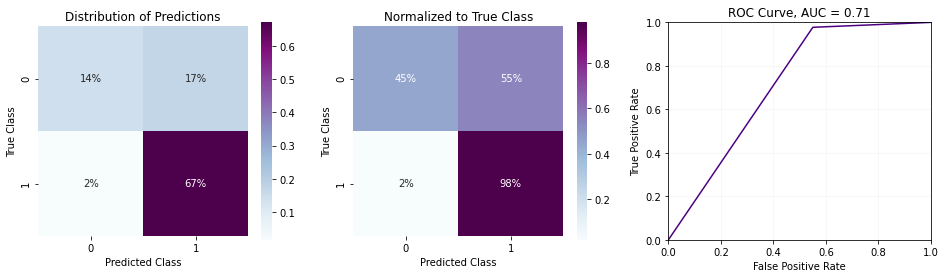

None

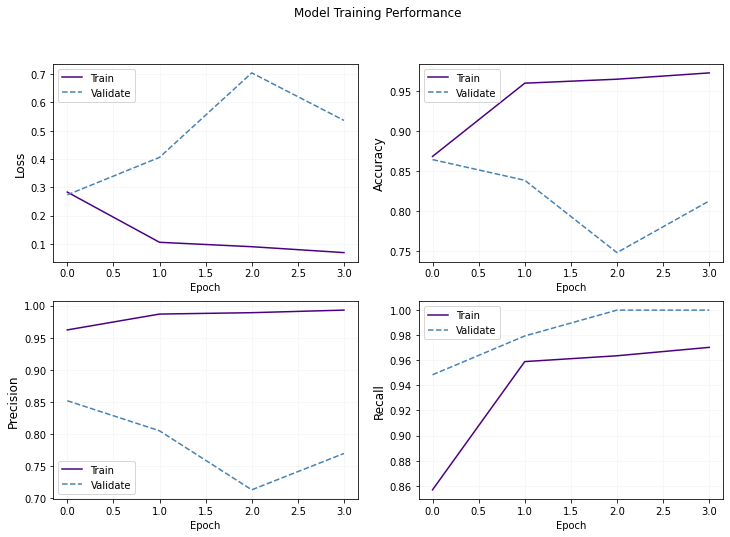

In [ ]:
display(evaluate_model(cnn2, test_images, test_labels))
plot_metrics(history2)

### Iteration : Deeper Network

In [ ]:
cnn1 = Sequential()
# First Conv layer
cnn1.add(Conv2D(64, (3, 3), input_shape = input_image_size, activation = 'relu'))
cnn1.add(Conv2D(64, (3, 3), activation = 'relu'))
cnn1.add(MaxPooling2D(pool_size = (2, 2)))
# Second Conv layer
cnn1.add(Conv2D(32, (3, 3), activation = 'relu'))
cnn1.add(MaxPooling2D(pool_size = (2, 2)))
# Flatten the Conv layers for input into dense layer
cnn1.add(Flatten())
# A hidden dense layer followed by the final binary classifying neuron
cnn1.add(Dense(units = 64, activation = 'relu'))
cnn1.add(Dense(units = 1, activation = 'sigmoid'))

# Compile the model and check architecture
cnn1.compile(optimizer = 'adam', 
                loss = 'binary_crossentropy',
                metrics = mod_metrics)
cnn1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 126, 126, 64)      1792      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 124, 124, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 60, 60, 32)        18464     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 28800)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)               

### Iteration : Image Augmentation
Data augmentation is the process of changing the training samples and adding them back into the set. It is used for enriching the diversity of training samples

In [ ]:
# Instantiate training set image generator
train_datagen_aug = ImageDataGenerator(rescale=(1./255)) # ADD AUGS
                                   
# Data used to train model
print(" Train:")
train_data_aug = train_datagen_aug.flow_from_directory(train_path, 
                                                    target_size=target_img_size,
                                                    batch_size=32, #get_num_images(train_path))  
                                                    class_mode='binary',
                                                    seed=seed) 

 Train:
Found 5216 images belonging to 2 classes.


#### Iteration : Image Size

### Iteration : Class imbalance manually corrected

TRY:
artifical up sample

downsample instead of weights

### Iteration : Regularize

Ideally, we are now at a place where we have a large model that is fitting at least the training set. Now it is time to regularize it and gain some validation accuracy by giving up some of the training accuracy. Some tips & tricks:

#### Iteration : Transfer Data / Pre-Train

# Evaluation


#### Final Model Arcitecture

In [ ]:
###TTOOODDDOOOOO: update with final model
#### update layer number and total channels for the visual plots
fin_model = cnn

# Load final model, examine arhitecture
# fin_model = load_model('chest_xray_all_data.h5')
fin_model.summary() 

In [ ]:
# Count convolution/pooling layers in model summary (everything before 'flat')
# for use in visualizing layers 
n = 2

# Number of channels in first convolutional layer
c0 = 64

# Number of channels in final convolutional layer (before flatten)
c1 = 32

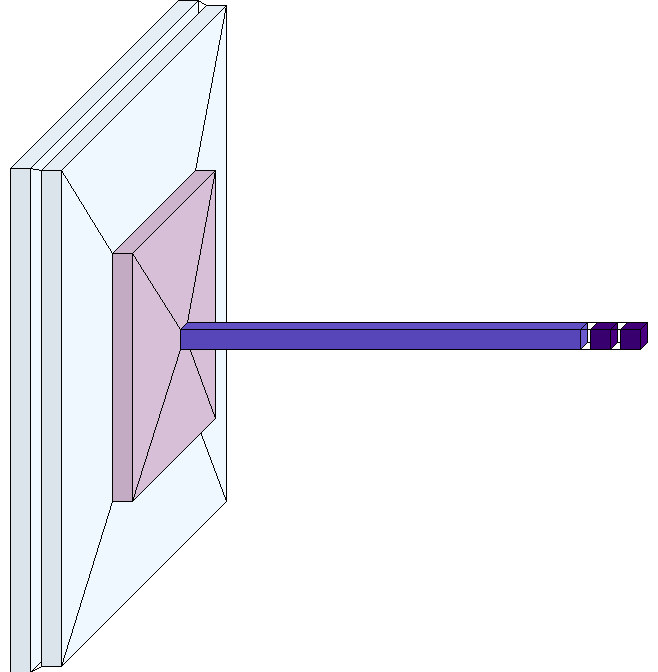

In [ ]:
# Visualize arcitecture of final model, save to project file
visualkeras.layered_view(fin_model, color_map = color_map, to_file = project_path+'visualkeras_#D.png')

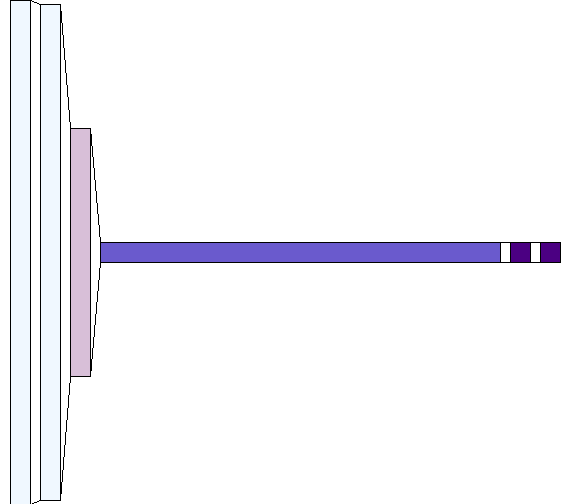

In [ ]:
# Flatttened visual, save to project file
visualkeras.layered_view(fin_model, draw_volume=False, color_map=color_map, to_file = project_path+'visualkeras_2D.png')

### Preprocess evalution images

Preprocess evalution images from untouched downloaded validation set of 16 image. Blind to all previous programming.

In [ ]:
# Preprocessing validation images the same as the model to use to predict
val_datagen = ImageDataGenerator(rescale=(1./255))
val_data = val_datagen.flow_from_directory(val_path, 
                                            target_size=target_img_size,
                                            batch_size=get_num_images(val_path),
                                            class_mode='binary')

# Get the images and labels as np.arrays                                          
val_imgs, val_labels = next(val_data)
val_key = val_data.class_indices
val_key

Found 16 images belonging to 2 classes.


{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
# Flip dict to be able to search by predicted class as key
pred_key = {value:key for key, value in val_key.items()}
pred_key

{0: 'NORMAL', 1: 'PNEUMONIA'}

In [ ]:
# Select a random training image and label to evalute
i = np.random.choice(range(len(val_labels)))
label = val_labels[i]
img = val_imgs[i]

# Format as 4D tensor for feature mapping
img_tensor = np.expand_dims(val_imgs[i], axis=0)
img_tensor.shape

(1, 128, 128, 3)

### Visualize intermediate layers

In [ ]:
# Extract model layer outputs, using 'n' number of convolutional layers
layer_outputs = [layer.output for layer in fin_model.layers[:n]]
layer_outputs
# Make a model to display the feature maps
activation_model = models.Model(inputs=fin_model.input, outputs=layer_outputs)

# Get feature maps for the layers
activations = activation_model.predict(img_tensor)

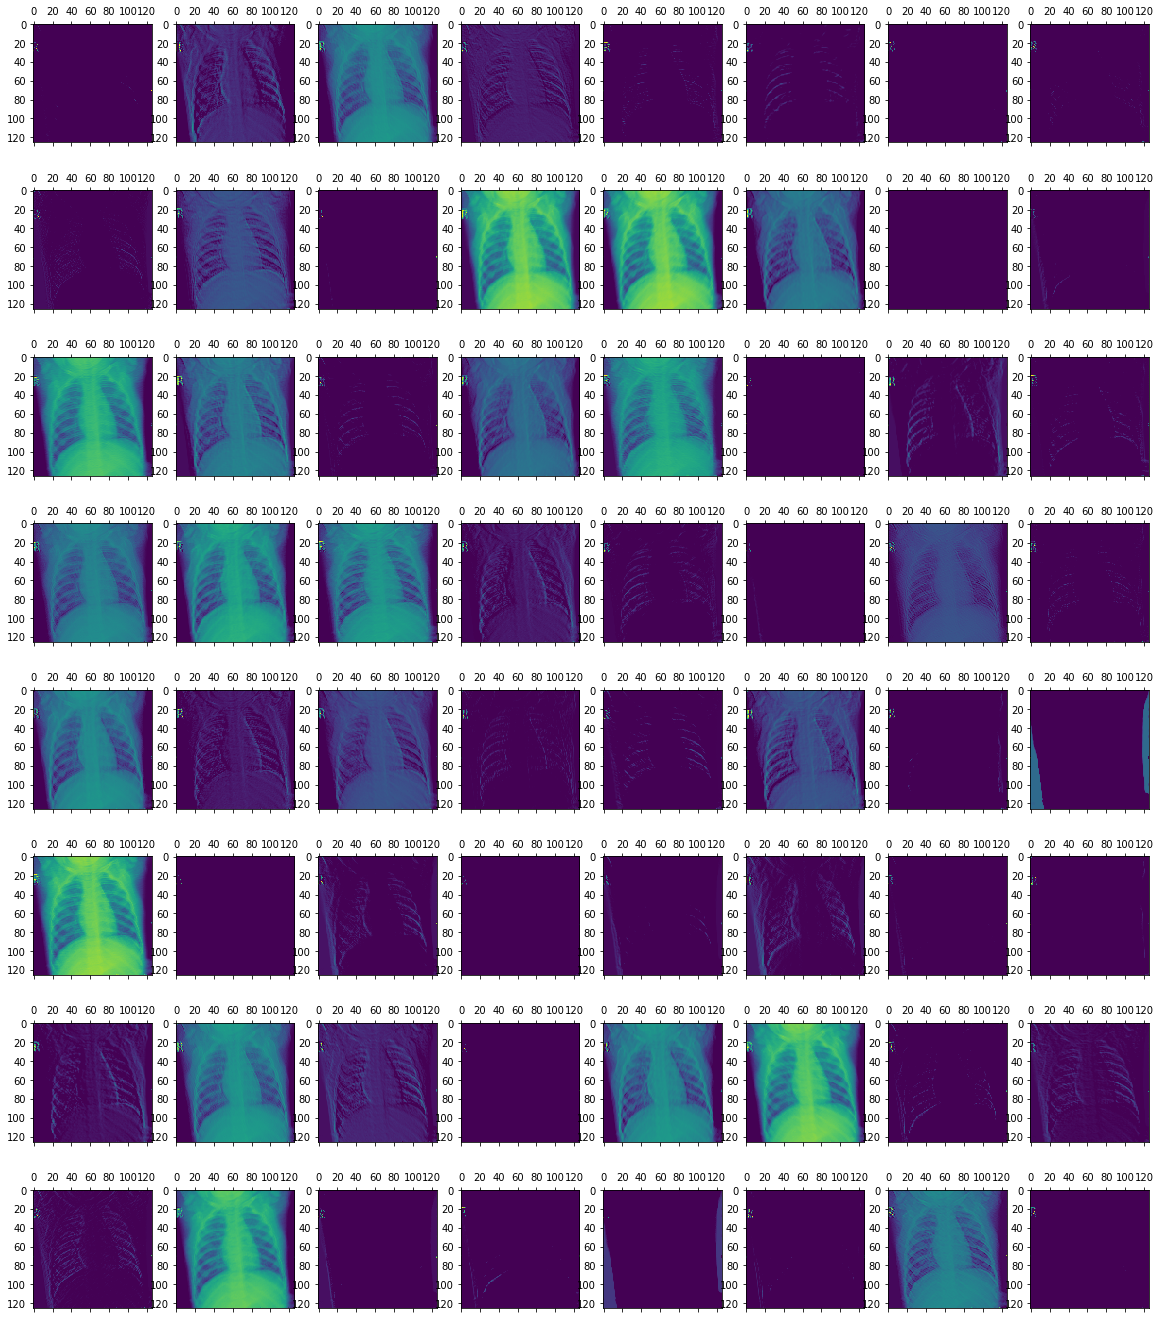

In [ ]:
# Visualize all channels from first activation layer
fig, axes = plt.subplots(8, 8, figsize=(20,24))
for i in range(c0):
    row = i//8
    column = i%8
    ax = axes[row, column]
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

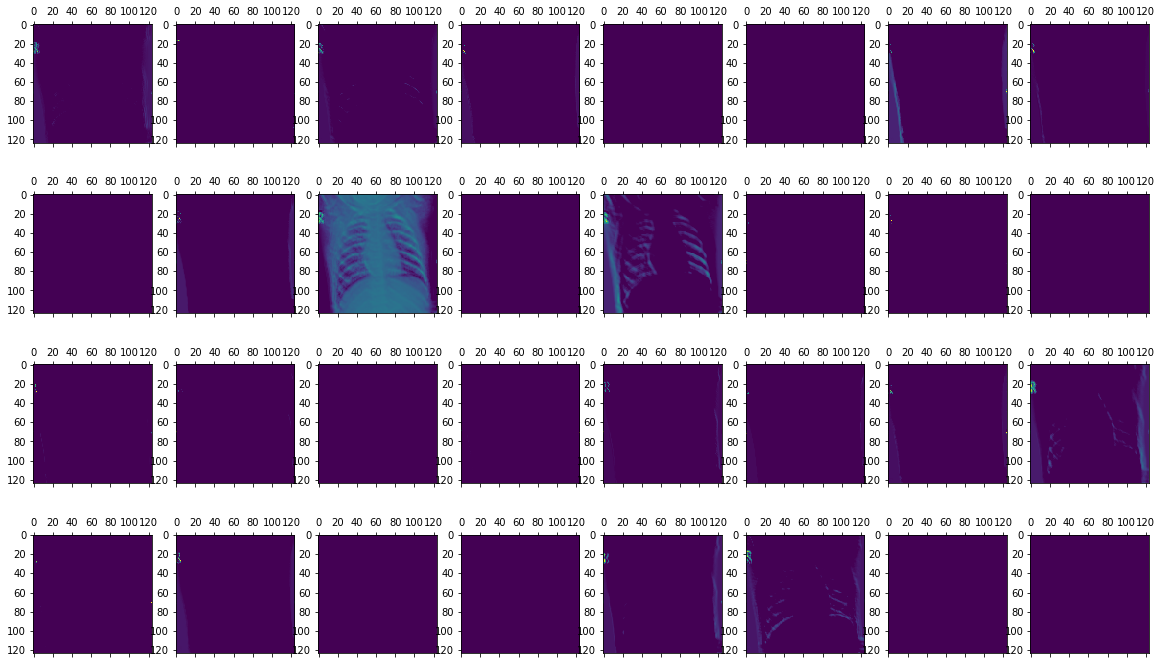

In [ ]:
# Visualize all channels from last convolutional activation layer
fig, axes = plt.subplots(4, 8, figsize=(20,12))
for i in range(c1):
    row = i//8
    column = i%8
    ax = axes[row, column]
    first_layer_activation = activations[n-1]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

### Image explanation with LIME

val image 31
Prediction: PNEUMONIA
Actual: NORMAL


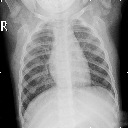

Incorrect!


In [ ]:
# Predict label and preview image
pred = int(fin_model.predict(np.array([img])).round())
print(f"val image {i}")
print("Prediction:", pred_key.get(pred))
print("Actual:", pred_key.get(label))
display(array_to_img(img))
print("Correct!") if pred_key.get(label) == pred_key.get(pred) else print("Incorrect!")

In [ ]:
# Make an explainer of image patterns identified (HOW is model working?)
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(img, cnn1.predict, top_labels=2,
                                         hide_color=None, num_samples=2000)

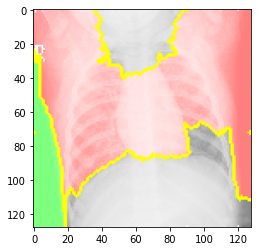

In [ ]:
# Select the same class explained by the image
class_exp =  explanation.top_labels[0]

# View the explainer over the image
temp, mask = explanation.get_image_and_mask(class_exp, 
                                            positive_only=False,
                                            num_features=5)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask));

Green shows what posittively contributed towards class prediction and red shows what negatively contributed (or contributed towards non-predicted class). Essentially green is the greatest 'pro' superpixel and red is the greatest'con' superpixel towards the finalized prediction. The larger superpixel indicates the predicted class (red: 0, normal; or green: 1, pneumonia).

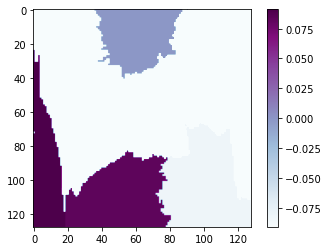

In [ ]:
#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[class_exp])
exp_map = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot, colorbar indications superpixel weights
plt.imshow(exp_map, cmap = 'BuPu', vmin  = -exp_map.max(), vmax = exp_map.max())
plt.colorbar()

This heatmap shows the segments learned by the model. The darker colors are the high positive (class 1, pneumonia) weights and the lighter colors indicate the negative class (0, normal). The red/green overlay on the x-ray show weights greater than (absolute) 0.1.

# Conclusion

***TODO summarize findings, give 3 reccomendations related to business problem and model performance


Possible reccomendations: disuss lowest image quality hat delivered results (can reduce from jump to minimize storage), recs on HOW to use model?

Be sure notebook answers these questions with clarity:

•	"How did you pick the question(s) that you did?"

•	"Why are these questions important from a business perspective?"

•	"How did you decide on the data cleaning options you performed?"

•	"Why did you choose a given method or library?"

•	"Why did you select these visualizations and what did you learn from each of them?"

•	"Why did you pick those features as predictors?"

•	"How would you interpret the results?"

•	"How confident are you in the predictive quality of the results?"

•	"What are some of the things that could cause the results to be wrong?"
